# CNN Character Recognition Model - Baseline

**Focus**: Build an interpretable, classic vision-driven model for character recognition.

## Model Architecture Intuition

This baseline CNN uses 3 convolutional layers to progressively learn character features:

### Layer-by-Layer Feature Detection:

**Layer 1 (32 filters, 3×3 kernels)**:
- Detects **low-level features**: edges, gradients, simple textures
- Identifies basic strokes (horizontal, vertical, diagonal lines)
- These are the building blocks of all characters

**Layer 2 (64 filters, 3×3 kernels)**:
- Detects **mid-level features**: corners, junctions, curves
- Combines edges to form simple shapes (circles, arcs, angles)
- Recognizes stroke patterns and intersections

**Layer 3 (128 filters, 3×3 kernels)**:
- Detects **high-level features**: character-specific parts
- Identifies loops (0, 6, 8, 9, a, b, d, g, o, p, q)
- Recognizes stems, crossbars, ascenders, descenders
- Combines mid-level features into complete character patterns

### Design Choices:
- **3×3 kernels**: Standard for capturing local spatial patterns
- **MaxPooling (2×2)**: Reduces spatial dimensions, creates translation invariance
- **BatchNormalization**: Stabilizes training, enables higher learning rates
- **Dropout (0.5)**: Regularization to prevent overfitting
- **Total params**: ~235K (lightweight, interpretable)

## Workflow:
1. Load training/test data (36 classes: 0-9, a-z)
2. Train small CNN on full training set
3. Evaluate on test set with detailed metrics
4. Analyze overfitting/underfitting
5. Save baseline model and results

## Import Libraries

In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import random
import time

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns

print(f"TensorFlow version: {tf.__version__}")
print(f"GPU available: {len(tf.config.experimental.list_physical_devices('GPU')) > 0}")

d:\software\Anaconda\envs\CS4243_lab\Lib\site-packages\h5py\__init__.py:36: UserWarning: h5py is running against HDF5 1.14.5 when it was built against 1.14.6, this may cause problems
  _warn(("h5py is running against HDF5 {0} when it was built against {1}, "


TensorFlow version: 2.20.0
GPU available: False


## Configuration

In [2]:
# Paths
TRAIN_DATA_DIR = Path('../Segmented_dataset/train_characters')
TEST_DATA_DIR = Path('../Segmented_dataset/test_characters')
MODEL_SAVE_DIR = Path('../models/saved_models')

# Training parameters
BATCH_SIZE = 32
NUM_EPOCHS = 20
LEARNING_RATE = 0.001
IMAGE_SIZE = 32
NUM_CLASSES = 36  # 0-9, a-z

# Character mapping
CHARACTERS = [str(i) for i in range(10)] + [chr(i) for i in range(ord('a'), ord('z') + 1)]
CHAR_TO_IDX = {char: idx for idx, char in enumerate(CHARACTERS)}
IDX_TO_CHAR = {idx: char for char, idx in CHAR_TO_IDX.items()}

# Set random seed for reproducibility
tf.random.set_seed(42)
np.random.seed(42)
random.seed(42)


## Data Loading (with Cache)


In [3]:
# Cache configuration
CACHE_DIR = Path('../Segmented_dataset/cache')
CACHE_DIR.mkdir(parents=True, exist_ok=True)

TRAIN_CACHE = CACHE_DIR / 'train_data.npz'
TEST_CACHE = CACHE_DIR / 'test_data.npz'

def save_data_cache(X, y, filenames, cache_path):
    """Save preprocessed data to disk"""
    np.savez_compressed(cache_path, 
                       X=X, 
                       y=y, 
                       filenames=filenames if filenames else [])
    print(f"Saved cache: {cache_path} ({cache_path.stat().st_size / 1024 / 1024:.1f} MB)")

def load_data_cache(cache_path):
    """Load preprocessed data from disk"""
    data = np.load(cache_path, allow_pickle=True)
    filenames = data['filenames'].tolist() if len(data['filenames']) > 0 else None
    print(f"Loaded from cache: {cache_path}")
    return data['X'], data['y'], filenames



## Load Training and Test Data

In [4]:
# Try to load from cache, otherwise load from images

def load_data(data_dir, name="Data", return_filenames=False):
    """
    Load character images and labels.
    
    Args:
        data_dir: Path to directory containing character folders
        name: Name for logging
        return_filenames: If True, also return filenames for string-level accuracy
    
    Returns:
        If return_filenames=False: (images, labels)
        If return_filenames=True: (images, labels, filenames)
    """
    data_dir = Path(data_dir)
    
    if not data_dir.exists():
        print(f"ERROR: Directory does not exist: {data_dir}")
        if return_filenames:
            return np.array([]), np.array([]), []
        else:
            return np.array([]), np.array([])
    
    images = []
    labels = []
    filenames = []
    
    print(f"Loading {name}...")
    for char_folder in sorted(data_dir.iterdir()):
        if char_folder.is_dir() and char_folder.name in CHARACTERS:
            label = CHAR_TO_IDX[char_folder.name]
            png_files = list(char_folder.glob('*.png'))
            print(f"  {char_folder.name}: {len(png_files)} files")
            
            for img_file in png_files:
                image = cv2.imread(str(img_file))
                if image is not None:
                    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32) / 255.0
                    images.append(image)
                    labels.append(label)
                    if return_filenames:
                        filenames.append(img_file.name)
    
    print(f"Total: {len(images)} samples\n")
    
    if return_filenames:
        return np.array(images), np.array(labels), filenames
    else:
        return np.array(images), np.array(labels)
        
# Load training data
if TRAIN_CACHE.exists():
    print("Loading training data from cache (fast)...")
    X_train, y_train, _ = load_data_cache(TRAIN_CACHE)
else:
    print("Loading training data from images (first time, slow)...")
    X_train, y_train = load_data(TRAIN_DATA_DIR, "Training Data", return_filenames=False)
    save_data_cache(X_train, y_train, None, TRAIN_CACHE)

# Load test data
if TEST_CACHE.exists():
    print("Loading test data from cache (fast)...")
    X_test, y_test, test_filenames = load_data_cache(TEST_CACHE)
else:
    print("Loading test data from images (first time, slow)...")
    X_test, y_test, test_filenames = load_data(TEST_DATA_DIR, "Test Data", return_filenames=True)
    save_data_cache(X_test, y_test, test_filenames, TEST_CACHE)

# Convert to categorical
y_train_cat = tf.keras.utils.to_categorical(y_train, NUM_CLASSES)
y_test_cat = tf.keras.utils.to_categorical(y_test, NUM_CLASSES)

# Summary
print(f"\n{'='*60}")
print(f"DATASET SUMMARY")
print(f"{'='*60}")
print(f"  Training:   {len(X_train):,} samples")
print(f"  Test:       {len(X_test):,} samples")
print(f"  Image size: {IMAGE_SIZE}x{IMAGE_SIZE}x3")
print(f"  Classes:    {NUM_CLASSES}")
print(f"{'='*60}")
print("Data ready for training")

Loading training data from cache (fast)...
Loaded from cache: ..\Segmented_dataset\cache\train_data.npz


Loading test data from cache (fast)...
Loaded from cache: ..\Segmented_dataset\cache\test_data.npz

DATASET SUMMARY
  Training:   46,244 samples
  Test:       9,280 samples
  Image size: 32x32x3
  Classes:    36
Data ready for training


## Model Definition

In [5]:
def create_cnn_model():
    """
    Create a 3-layer CNN for character recognition.
    
    Architecture reasoning:
    - Layer 1: Detects edges and basic strokes
    - Layer 2: Detects corners and simple shapes
    - Layer 3: Detects character-specific features
    """
    model = Sequential([
        # First convolutional block - Edge detectors
        Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), 
               name='conv1_edges'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        
        # Second convolutional block - Shape detectors
        Conv2D(64, (3, 3), activation='relu', name='conv2_shapes'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        
        # Third convolutional block - Character part detectors
        Conv2D(128, (3, 3), activation='relu', name='conv3_parts'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        
        # Fully connected layers
        Flatten(),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(NUM_CLASSES, activation='softmax')
    ])
    return model

# Create and compile model
model = create_cnn_model()
model.compile(optimizer=Adam(learning_rate=LEARNING_RATE),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

print("Model Architecture:")
model.summary()
print(f"Total parameters: {model.count_params():,}")

d:\software\Anaconda\envs\CS4243_lab\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model Architecture:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1_edges (Conv2D)            │ (None, 30, 30, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 30, 30, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2_shapes (Conv2D)           │ (None, 13, 13, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 13, 13, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3_parts (Conv2D)            │ (None, 4, 4, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 4, 4, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 2, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 36)             │         9,252 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 234,724 (916.89 KB)

 Trainable params: 234,276 (915.14 KB)

 Non-trainable params: 448 (1.75 KB)

Total parameters: 234,724


## Training Setup

In [6]:
# Setup training callbacks
callbacks = [
    ReduceLROnPlateau(
        monitor='loss',
        factor=0.5,
        patience=3,
        min_lr=1e-7,
        verbose=1
    )
]


## Train Model

In [7]:
# Train the model on full training set
print("Starting training...")
print(f"  Training samples: {len(X_train):,}")
print(f"  Epochs: {NUM_EPOCHS}")
print(f"  Batch size: {BATCH_SIZE}\n")

start_time = time.time()

history = model.fit(
    X_train, y_train_cat,
    batch_size=BATCH_SIZE,
    epochs=NUM_EPOCHS,
    callbacks=callbacks,
    verbose=1
)

training_time = time.time() - start_time

print(f"\nTraining completed in {training_time:.1f} seconds ({training_time/60:.1f} minutes)")
print(f"  Final training accuracy: {history.history['accuracy'][-1]:.4f}")

Starting training...
  Training samples: 46,244
  Epochs: 20
  Batch size: 32

Epoch 1/20
1446/1446 ━━━━━━━━━━━━━━━━━━━━ 23s 14ms/step - accuracy: 0.4254 - loss: 2.0628 - learning_rate: 0.0010
Epoch 2/20
1446/1446 ━━━━━━━━━━━━━━━━━━━━ 20s 14ms/step - accuracy: 0.6210 - loss: 1.2747 - learning_rate: 0.0010
Epoch 3/20
1446/1446 ━━━━━━━━━━━━━━━━━━━━ 21s 14ms/step - accuracy: 0.6715 - loss: 1.0870 - learning_rate: 0.0010
Epoch 4/20
1446/1446 ━━━━━━━━━━━━━━━━━━━━ 22s 15ms/step - accuracy: 0.7054 - loss: 0.9665 - learning_rate: 0.0010
Epoch 5/20
1446/1446 ━━━━━━━━━━━━━━━━━━━━ 20s 14ms/step - accuracy: 0.7219 - loss: 0.8878 - learning_rate: 0.0010
Epoch 6/20
1446/1446 ━━━━━━━━━━━━━━━━━━━━ 20s 14ms/step - accuracy: 0.7420 - loss: 0.8179 - learning_rate: 0.0010
Epoch 7/20
1446/1446 ━━━━━━━━━━━━━━━━━━━━ 21s 14ms/step - accuracy: 0.7567 - loss: 0.7643 - learning_rate: 0.0010
Epoch 8/20
1446/1446 ━━━━━━━━━━━━━━━━━━━━ 20s 14ms/step - accuracy: 0.7699 - loss: 0.7117 - learning_rate: 0.0010
Epoch 9/2

## Helper Functions for Evaluation


In [8]:
def calculate_string_accuracy(y_pred, y_test, filenames, idx_to_char):
    """
    Calculate string-level (complete CAPTCHA) accuracy.
    
    Returns: (string_accuracy, correct, total, captcha_pred, captcha_true, stats)
    """
    from collections import defaultdict
    
    captcha_pred = defaultdict(dict)
    captcha_true = defaultdict(dict)
    skipped = 0
    
    # Group characters by CAPTCHA ID
    for i, filename in enumerate(filenames):
        parts = filename.split('_')
        if len(parts) >= 3:
            last_part = parts[-1].replace('.png', '')
            if '-' in last_part:
                captcha_id, pos = last_part.rsplit('-', 1)
                pos = int(pos)
                captcha_pred[captcha_id][pos] = idx_to_char[y_pred[i]]
                captcha_true[captcha_id][pos] = idx_to_char[y_test[i]]
            else:
                skipped += 1
        else:
            skipped += 1
    
    # Calculate accuracy
    correct = sum(1 for cid in captcha_pred 
                  if ''.join(captcha_pred[cid][p] for p in sorted(captcha_pred[cid].keys())) == 
                     ''.join(captcha_true[cid][p] for p in sorted(captcha_true[cid].keys())))
    
    accuracy = correct / len(captcha_pred) if captcha_pred else 0
    
    # Statistics
    stats = {
        'total_chars': len(filenames),
        'parsed_chars': sum(len(captcha_pred[cid]) for cid in captcha_pred),
        'skipped_chars': skipped,
        'captchas': len(captcha_pred),
        'avg_chars_per_captcha': sum(len(captcha_pred[cid]) for cid in captcha_pred) / len(captcha_pred) if captcha_pred else 0
    }
    
    return accuracy, correct, len(captcha_pred), captcha_pred, captcha_true, stats


## Evaluate on Test Set (Character & String Level)

In [9]:
# Evaluate on test set
test_loss, test_accuracy = model.evaluate(X_test, y_test_cat, verbose=1)
y_pred_proba = model.predict(X_test, verbose=0)
y_pred = np.argmax(y_pred_proba, axis=1)

# Calculate string-level accuracy
string_accuracy, correct_captchas, total_captchas, captcha_predictions, captcha_ground_truth, stats = \
    calculate_string_accuracy(y_pred, y_test, test_filenames, IDX_TO_CHAR)

# Display results
print(f"\n{'='*60}")
print(f"ACCURACY SUMMARY")
print(f"{'='*60}")
print(f"Character Level:")
print(f"  Loss: {test_loss:.4f} | Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
print(f"  Correct: {int(test_accuracy * len(X_test)):,}/{len(X_test):,} characters")
print(f"\nString Level (Complete CAPTCHA):")
print(f"  Accuracy: {string_accuracy:.4f} ({string_accuracy*100:.2f}%)")
print(f"  Correct: {correct_captchas:,}/{total_captchas:,} CAPTCHAs")
print(f"  Avg chars/CAPTCHA: {stats['avg_chars_per_captcha']:.2f}")
print(f"{'='*60}")

290/290 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.8375 - loss: 0.5750

ACCURACY SUMMARY
Character Level:
  Loss: 0.5750 | Accuracy: 0.8375 (83.75%)
  Correct: 7,771/9,280 characters

String Level (Complete CAPTCHA):
  Accuracy: 0.4390 (43.90%)
  Correct: 684/1,558 CAPTCHAs
  Avg chars/CAPTCHA: 5.96


## Training Curve Visualization

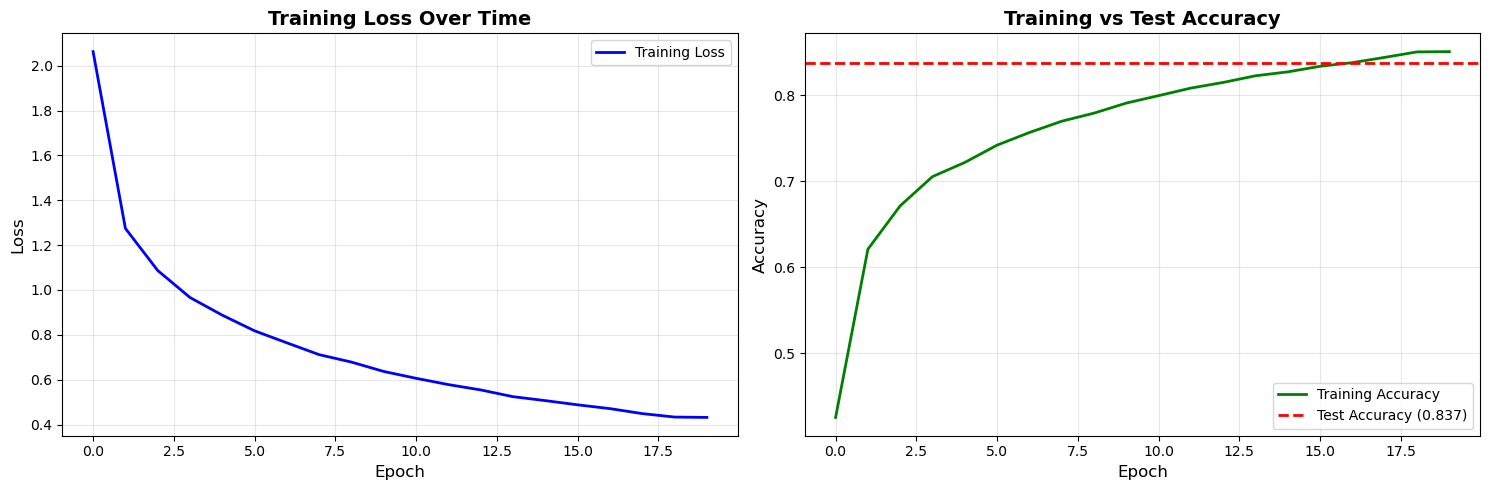


OVERFITTING ANALYSIS
Train: 0.8508 (85.08%) | Test: 0.8375 (83.75%) | Gap: 0.0133 (1.33%)

GOOD GENERALIZATION (gap < 5%)


In [10]:
# Plot training history with analysis
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Loss curve
ax1.plot(history.history['loss'], label='Training Loss', linewidth=2, color='blue')
ax1.set_title('Training Loss Over Time', fontsize=14, fontweight='bold')
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Loss', fontsize=12)
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)

# Accuracy curve
ax2.plot(history.history['accuracy'], label='Training Accuracy', linewidth=2, color='green')
ax2.axhline(y=test_accuracy, color='red', linestyle='--', linewidth=2, label=f'Test Accuracy ({test_accuracy:.3f})')
ax2.set_title('Training vs Test Accuracy', fontsize=14, fontweight='bold')
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('Accuracy', fontsize=12)
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Analyze overfitting/underfitting
train_acc_final = history.history['accuracy'][-1]
gap = train_acc_final - test_accuracy

print(f"\n{'='*60}")
print(f"OVERFITTING ANALYSIS")
print(f"{'='*60}")
print(f"Train: {train_acc_final:.4f} ({train_acc_final*100:.2f}%) | Test: {test_accuracy:.4f} ({test_accuracy*100:.2f}%) | Gap: {gap:.4f} ({gap*100:.2f}%)")

if gap > 0.15:
    print(f"\nSEVERE OVERFITTING (gap > 15%)")
elif gap > 0.05:
    print(f"\nMODERATE OVERFITTING (gap 5-15%)")
else:
    print(f"\nGOOD GENERALIZATION (gap < 5%)")
if train_acc_final < 0.7:
    print(f"\nUNDERFITTING (train < 70%)")

print(f"{'='*60}")

## Confusion Matrix & Classification Report


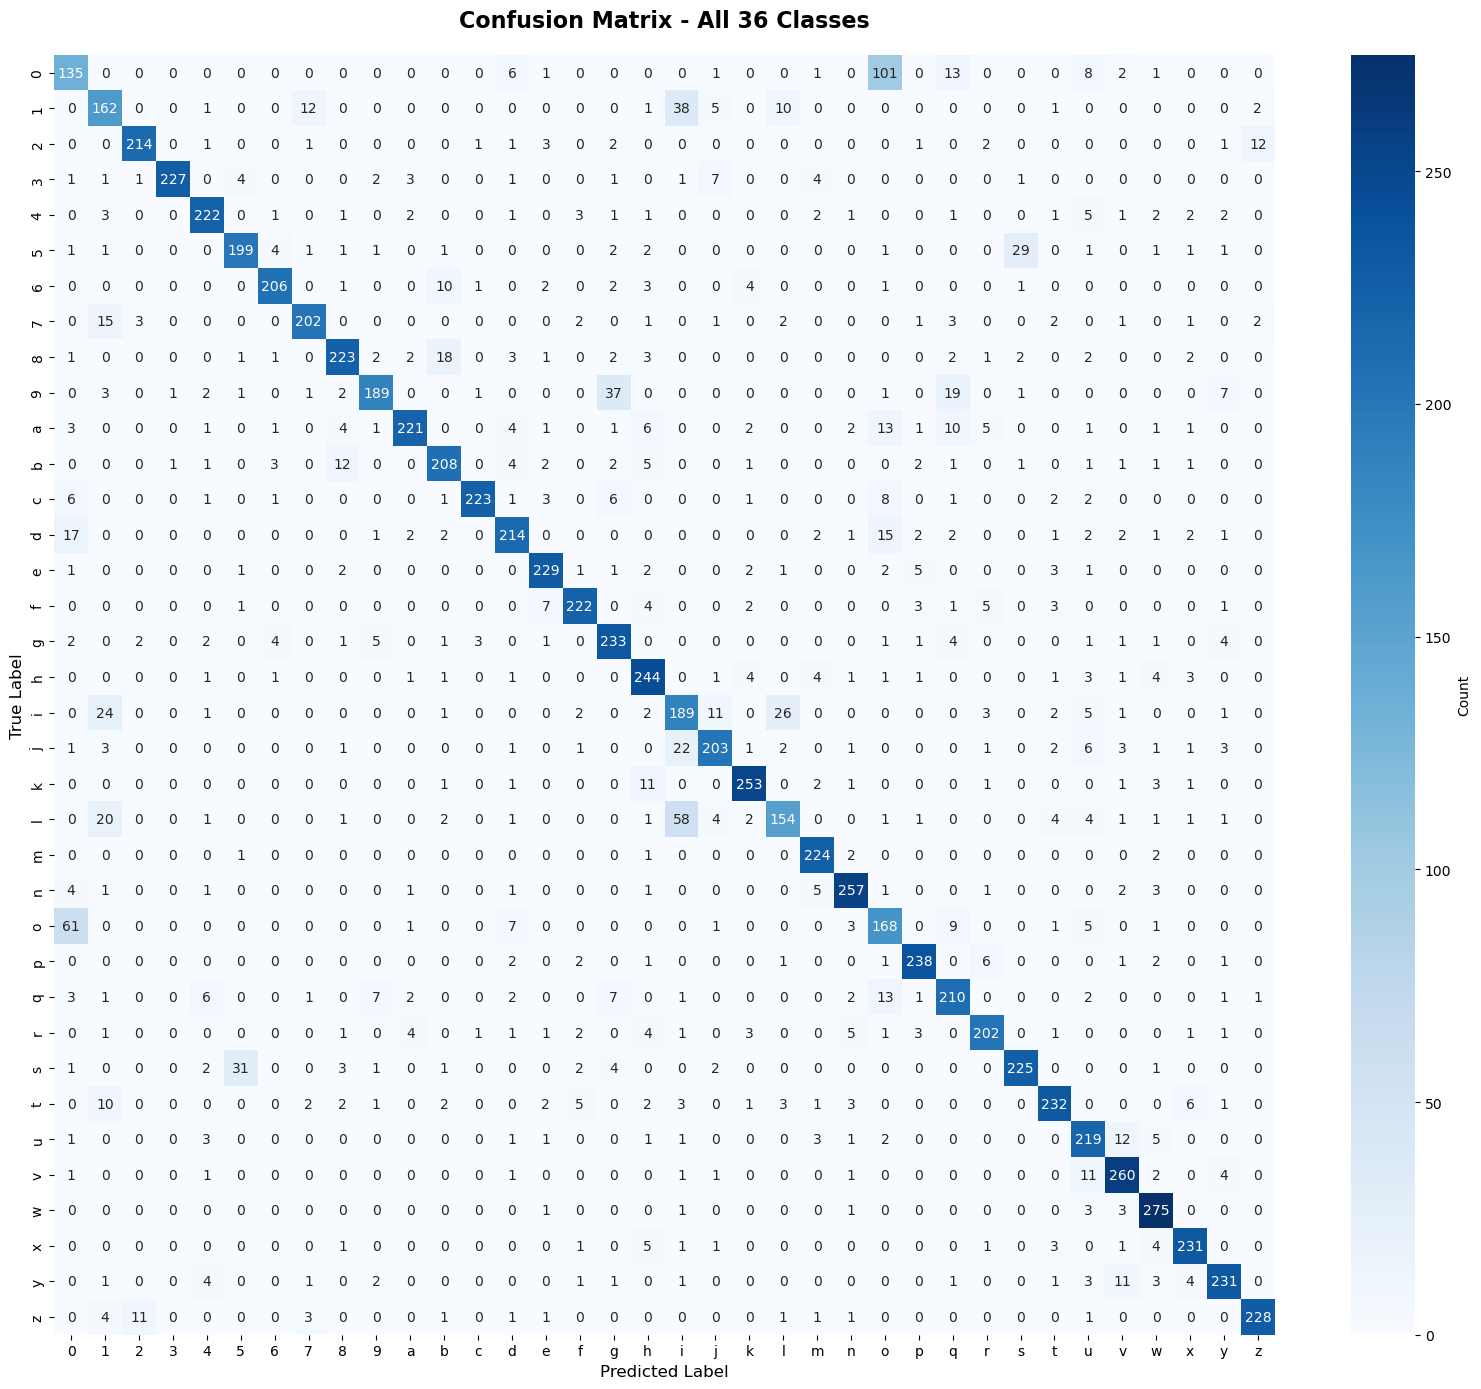


CLASSIFICATION REPORT
              precision    recall  f1-score   support

           0       0.56      0.50      0.53       269
           1       0.65      0.70      0.67       232
           2       0.93      0.90      0.91       239
           3       0.99      0.89      0.94       254
           4       0.88      0.88      0.88       252
           5       0.83      0.81      0.82       247
           6       0.93      0.89      0.91       231
           7       0.90      0.86      0.88       236
           8       0.87      0.84      0.85       266
           9       0.89      0.71      0.79       265
           a       0.92      0.79      0.85       279
           b       0.83      0.84      0.84       247
           c       0.97      0.87      0.92       256
           d       0.84      0.80      0.82       267
           e       0.89      0.91      0.90       251
           f       0.91      0.89      0.90       249
           g       0.77      0.87      0.82       267
    

In [11]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix (all 36 classes)
plt.figure(figsize=(16, 14))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=CHARACTERS, yticklabels=CHARACTERS,
            cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix - All 36 Classes', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.tight_layout()
plt.show()

# Classification report
print("\n" + "="*60)
print("CLASSIFICATION REPORT")
print("="*60)
report = classification_report(y_test, y_pred, target_names=CHARACTERS, zero_division=0)
print(report)

# Per-class accuracy
print("\n" + "="*60)
print("PER-CLASS ACCURACY")
print("="*60)
for i, char in enumerate(CHARACTERS):
    mask = y_test == i
    if mask.sum() > 0:
        acc = (y_pred[mask] == i).sum() / mask.sum()
        print(f"  {char}: {acc:.4f} ({acc*100:.2f}%) - {mask.sum()} samples")

print("="*60)


## Sample Predictions Visualization


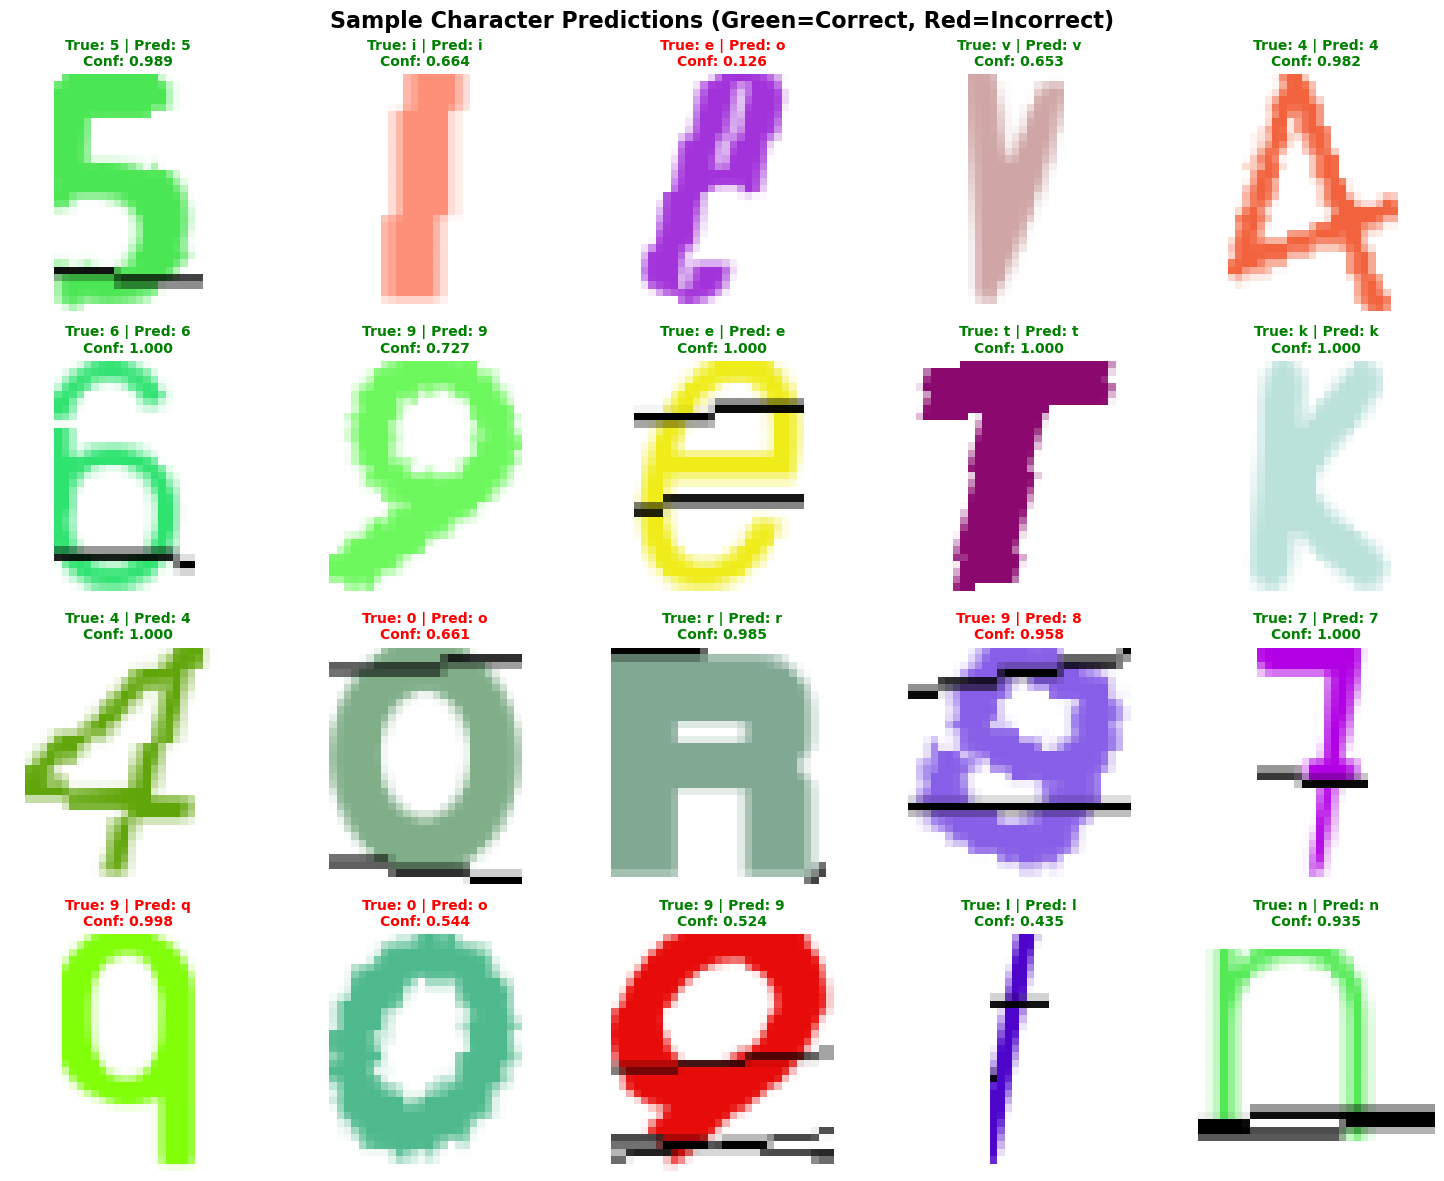

Sample character predictions displayed

SAMPLE COMPLETE CAPTCHA PREDICTIONS
  002e23-0: True=002e23 | Pred=002e23 | CORRECT
  03yl9s-0: True=03yl9s | Pred=03y19s | WRONG
  03yuav5-0: True=03yuav5 | Pred=03yuov5 | WRONG
  03zl9o-0: True=03zl9o | Pred=o3zl9o | WRONG
  05htm-0: True=05htm | Pred=05htm | CORRECT
  05pb-0: True=05pb | Pred=05pb | CORRECT
  07oj-0: True=07oj | Pred=07oj | CORRECT
  07z0-0: True=07z0 | Pred=01z0 | WRONG
  08ft2e2z-0: True=08ft2e2z | Pred=o8ft2e2z | WRONG
  08nxd77-0: True=08nxd77 | Pred=08nxd77 | CORRECT


In [12]:
# Show sample predictions
num_samples = 20
indices = np.random.choice(len(X_test), num_samples, replace=False)

fig, axes = plt.subplots(4, 5, figsize=(15, 12))
axes = axes.ravel()

for i, idx in enumerate(indices):
    img = X_test[idx]
    true_label = y_test[idx]
    pred_label = y_pred[idx]
    confidence = y_pred_proba[idx][pred_label]
    
    true_char = IDX_TO_CHAR[true_label]
    pred_char = IDX_TO_CHAR[pred_label]
    
    # Determine color
    color = 'green' if true_label == pred_label else 'red'
    
    # Plot
    axes[i].imshow(img)
    axes[i].set_title(f'True: {true_char} | Pred: {pred_char}\nConf: {confidence:.3f}', 
                     color=color, fontsize=10, fontweight='bold')
    axes[i].axis('off')

plt.suptitle('Sample Character Predictions (Green=Correct, Red=Incorrect)', 
             fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

print("Sample character predictions displayed")

# Show complete CAPTCHA predictions (string-level)
print(f"\n{'='*60}")
print(f"SAMPLE COMPLETE CAPTCHA PREDICTIONS")
print(f"{'='*60}")

for captcha_id in list(captcha_predictions.keys())[:10]:
    pred_str = ''.join([captcha_predictions[captcha_id][p] for p in sorted(captcha_predictions[captcha_id].keys())])
    true_str = ''.join([captcha_ground_truth[captcha_id][p] for p in sorted(captcha_ground_truth[captcha_id].keys())])
    status = "CORRECT" if pred_str == true_str else "WRONG"
    print(f"  {captcha_id}: True={true_str} | Pred={pred_str} | {status}")

print(f"{'='*60}")


## Save Model


In [13]:
# Save model
MODEL_SAVE_DIR.mkdir(parents=True, exist_ok=True)
model_path = MODEL_SAVE_DIR / 'cnn_character_recognition.keras'
model.save(model_path)
print(f"Model saved to: {model_path}")


Model saved to: ..\models\saved_models\cnn_character_recognition.keras
